In [1]:
%reset -f

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Input, Flatten, Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
# import pydot
# import graphviz
import numpy as np
import os
import math
import skimage
from skimage import io  # for reading TIFF images
from tqdm import tqdm  # for progress bars
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# training parameters
batch_size = 128
epochs = 140
data_augmentation = False

# network parameters
num_classes = 1
num_dense_blocks = 3
use_max_pool = True

# DenseNet-BC with dataset augmentation
# Growth rate   | Depth |  Accuracy (paper)| Accuracy (this)      |
# 12            | 100   |  95.49%          | 93.74%               |
# 24            | 250   |  96.38%          | requires big mem GPU |
# 40            | 190   |  96.54%          | requires big mem GPU |
growth_rate = 12
depth = 100
num_bottleneck_layers = (depth - 4) // (2 * num_dense_blocks)

num_filters_bef_dense_block = 2 * growth_rate
compression_factor = 0.5

In [ ]:
# Set the desired number of patches
desired_num_patches = 15000

# Your data directories
optic_images_dir = 'Sentinel-2-patches/'
sar_images_dir = 'Sentinel-1-patches/'
agb_maps_dir = 'AGB_Patches/AGB_Patches'

# Get the list of file names in the directories without sorting
agb_map_files = os.listdir(agb_maps_dir)
optic_image_files = os.listdir(optic_images_dir)
sar_image_files = os.listdir(sar_images_dir)

In [9]:


# Initialize empty lists to store data
x_train_list = []
y_train_list = []
agb_values_list = []

# Loop through each patch with tqdm for progress bars
# Loop through each patch with tqdm for progress bars
for i in tqdm(range(desired_num_patches), desc='Loading Patches'):
    # Get file names for the current index
    optic_file = optic_image_files[i]
    sar_file = sar_image_files[i]
    agb_file = agb_map_files[i]
    # Load images
    optic_image = io.imread(os.path.join(optic_images_dir, optic_file))
    sar_image = io.imread(os.path.join(sar_images_dir, sar_file))
    agb_map = io.imread(os.path.join(agb_maps_dir, agb_file))

    # Save AGB values as a NumPy array
    agb_values_list.append(agb_map.flatten())

    # Ensure optic image has 13 bands
    if optic_image.shape[-1] == 13:
        x_train = optic_image
    else:
        raise ValueError("Optic image should have 13 bands. Found: {}".format(optic_image.shape[-1]))

    # Check if SAR image has 2 bands
    if len(sar_image.shape) == 2:
        # Expand dimensions to make it 3D
        sar_image = np.stack([sar_image, sar_image], axis=-1)

    # Normalize the data using min-max scaling
    optic_image_normalized = (optic_image - np.min(optic_image)) / (np.max(optic_image) - np.min(optic_image))
    sar_image_normalized = (sar_image - np.min(sar_image)) / (np.max(sar_image) - np.min(sar_image))

    # Concatenate optic and SAR images
    x_train = np.concatenate([optic_image_normalized, sar_image_normalized], axis=-1)

    x_train_list.append(x_train)

    # Break the loop when desired_num_patches is reached
    if len(x_train_list) >= desired_num_patches:
        break

# Combine all patches into single arrays
x_data = np.stack(x_train_list)
agb_values = np.concatenate(agb_values_list)

# Normalize AGB values using min-max scaling
min_agb = np.min(agb_values)
max_agb = np.max(agb_values)
agb_scaled = (agb_values - min_agb) / (max_agb - min_agb)

# Reshape scaled AGB values for compatibility with the model
agb_normalized = np.expand_dims(agb_scaled, axis=-1)

# Split the data into training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, agb_normalized, test_size=0.20, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)
input_shape = x_train.shape[1:]

Loading Patches: 100%|█████████▉| 14999/15000 [00:25<00:00, 580.51it/s]


: 

In [6]:
min_agb = np.min(agb_values)
max_agb = np.max(agb_values)
print(min_agb)
print(max_agb)

0
306158


In [4]:
min_agb = 0
max_agb = 306158

In [5]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [6]:
# start model definition
# densenet CNNs (composite function) are made of BN-ReLU-Conv2D
inputs = Input(shape=input_shape)
x = BatchNormalization()(inputs)
x = Activation('relu')(x)
x = Conv2D(num_filters_bef_dense_block,
           kernel_size=3,
           padding='same',
           kernel_initializer='he_normal')(x)
x = concatenate([inputs, x])

# stack of dense blocks bridged by transition layers
for i in range(num_dense_blocks):
    # a dense block is a stack of bottleneck layers
    for j in range(num_bottleneck_layers):
        y = BatchNormalization()(x)
        y = Activation('relu')(y)
        y = Conv2D(4 * growth_rate,
                   kernel_size=1,
                   padding='same',
                   kernel_initializer='he_normal')(y)
        if not data_augmentation:
            y = Dropout(0.2)(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(growth_rate,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal')(y)
        if not data_augmentation:
            y = Dropout(0.2)(y)
        x = concatenate([x, y])

    # no transition layer after the last dense block
    if i == num_dense_blocks - 1:
        continue

    # transition layer compresses num of feature maps and reduces the size by 2
    num_filters_bef_dense_block += num_bottleneck_layers * growth_rate
    num_filters_bef_dense_block = int(num_filters_bef_dense_block * compression_factor)
    y = BatchNormalization()(x)
    y = Conv2D(num_filters_bef_dense_block,
               kernel_size=1,
               padding='same',
               kernel_initializer='he_normal')(y)
    if not data_augmentation:
        y = Dropout(0.2)(y)
    x = AveragePooling2D()(y)


# add classifier on top
# after average pooling, size of feature map is 1 x 1
x = AveragePooling2D(pool_size=8)(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                kernel_initializer='he_normal',
                activation='sigmoid')(y)


In [7]:
# instantiate and compile model
# orig paper uses SGD but RMSprop works better for DenseNet
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mean_squared_error',
              optimizer=RMSprop(1e-3),
              metrics=['mae'])
model.summary()
# enable this if pydot can be installed
# pip install pydot
#plot_model(model, to_file="cifar10-densenet.png", show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 90, 90, 15)] 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 90, 90, 15)   60          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 90, 90, 15)   0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 24)   3264        activation[0][0]                 
______________________________________________________________________________________________

In [8]:
# prepare model model saving directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'AGB_densenet_model.{epoch:02d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# prepare callbacks for model saving and for learning rate reducer
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=False,
                             save_weights_only=False,  # Save the entire model, not just the weights
                             mode='auto',  # Automatically determine the mode based on the quantity being monitored
                             period=1)  # Save at the end of every epoch

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# run training, with or without data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # preprocessing  and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (deg 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_train)

    steps_per_epoch = math.ceil(len(x_train) / batch_size)
    # fit the model on the batches generated by datagen.flow().
    history = model.fit(x=datagen.flow(x_train, y_train, batch_size=batch_size),
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),
              steps_per_epoch=steps_per_epoch,
              callbacks=callbacks)


    # fit the model on the batches generated by datagen.flow()
    #model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
    ##                    steps_per_epoch=x_train.shape[0] // batch_size,
    #                    validation_data=(x_test, y_test),
    #                    epochs=epochs, verbose=1,
    #                    callbacks=callbacks)

# score trained model
scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


Not using data augmentation.
Epoch 1/130
Learning rate:  0.001
1200/1200 [==============================] - 222s 172ms/step - loss: 0.0239 - mae: 0.1064 - val_loss: 0.0069 - val_mae: 0.0631

Epoch 00001: saving model to c:\Users\Green\Documents\Mr.Irannejed\saved_models\AGB_densenet_model.01.h5
Epoch 2/130
Learning rate:  0.001
1200/1200 [==============================] - 203s 169ms/step - loss: 0.0117 - mae: 0.0765 - val_loss: 0.1874 - val_mae: 0.2480

Epoch 00002: saving model to c:\Users\Green\Documents\Mr.Irannejed\saved_models\AGB_densenet_model.02.h5
Epoch 3/130
Learning rate:  0.001
1200/1200 [==============================] - 203s 169ms/step - loss: 0.0103 - mae: 0.0702 - val_loss: 0.0059 - val_mae: 0.0511

Epoch 00003: saving model to c:\Users\Green\Documents\Mr.Irannejed\saved_models\AGB_densenet_model.03.h5
Epoch 4/130
Learning rate:  0.001
1200/1200 [==============================] - 204s 170ms/step - loss: 0.0087 - mae: 0.0662 - val_loss: 0.0047 - val_mae: 0.0493

Epoch 00

In [ ]:
y_pred1 = model.predict(x_test)
y_pred = y_pred1 * (max_agb - min_agb) + min_agb
y_test2 = y_test * (max_agb - min_agb) + min_agb

In [14]:
model.save('your_model.h5')

In [11]:
# Calculate R^2
r2 = r2_score(y_test2, y_pred)

NameError: name 'y_test2' is not defined

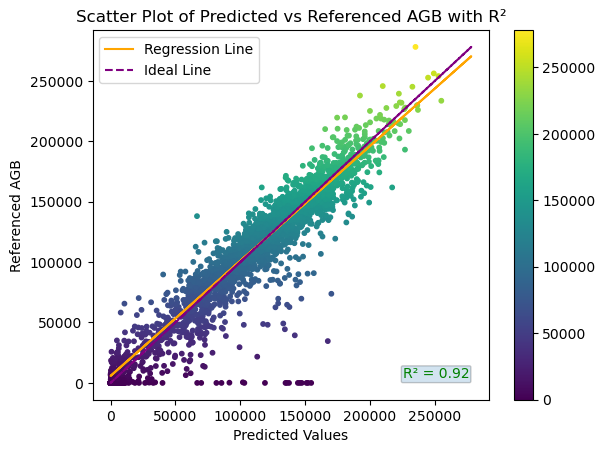

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape arrays if needed
y_test2 = np.array(y_test2).flatten()
y_pred = np.array(y_pred).flatten()

# Calculate regression line
regression_line = np.polyfit(y_test2, y_pred, 1)
poly_y = np.polyval(regression_line, y_test2)

# Scatter plot with gradient color and smaller points, switching x and y values
scatter = plt.scatter(y_pred, y_test2, c=y_test2, cmap='viridis', s=10)

# Plot true regression line
plt.plot(y_test2, poly_y, color='orange', label='Regression Line')

# Plot ideal line (y = x)
plt.plot(y_test2, y_test2, color='purple', linestyle='--', label='Ideal Line')

# Annotate R^2 value creatively
annotation_text = f'R² = {r2:.2f}'
plt.annotate(annotation_text, xy=(0.95, 0.05), xycoords='axes fraction',
             fontsize=10, ha='right', va='bottom', color='green', bbox=dict(boxstyle="round,pad=0.1", alpha=0.2))

# Add labels, legend, and colorbar
plt.xlabel('Predicted Values')
plt.ylabel('Referenced AGB')
plt.title('Scatter Plot of Predicted vs Referenced AGB with R²')
plt.legend()
plt.colorbar(scatter)

# Save the plot as a high-quality PNG image with smaller points
plt.savefig('scatter_plot_creative_annotation_switched_axes.png', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
true_agb_values = y_test2
# Use true_agb_values as y_true
y_true = true_agb_values
y_pred_classes = np.argmax(y_pred)
y_true_classes = np.argmax(y_test2)
# Calculate Mean Squared Error
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse}')
# Calculate Root Mean Squared Error
rmse = math.sqrt(mse)
print('Root Mean Squared Error:', rmse)

Mean Squared Error (MSE): 302364921.0900023
Root Mean Squared Error: 17388.643451690023


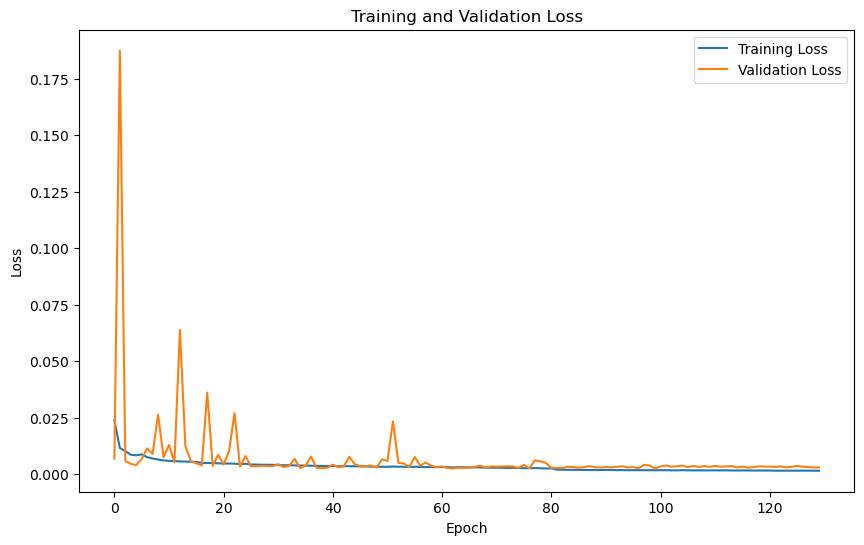

In [12]:
# Plot the loss diagram
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Training and Validation Loss.png', dpi=600, bbox_inches='tight')
plt.show()



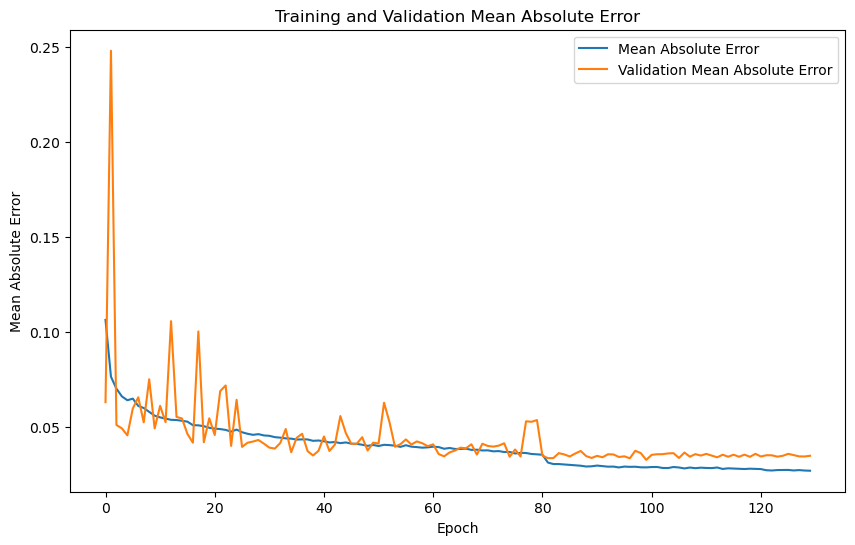

In [11]:
# Plot the accuracy diagram
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Mean Absolute Error')
plt.plot(history.history['val_mae'], label='Validation Mean Absolute Error')
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.savefig('Training and Validation Mean Absolute Error.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
plot_model(model, to_file="%s.png" , show_shapes=True, dpi=600)